# Sampling Strategy code development for ligands selection

B) Ligands sampling dataframe:

3) Ligands that have covalent Metal-Ligand connections to specific atoms (e.g. M*-C* bonds) Select highest-propensity ligands from across the CSD. (Top N most frequent present - guessing ~20 would be good start)
4) Ligands that have non-covalent (not first-coordination shell) metal-ligand connections to specific atoms (e.g. M*-N-C* bonds) from across the CSD. (Top N most frequent present - guessing ~20 would be good start)
5) Ensure that ligands selected cover as much known differences in chemistry as possible (e.g. Oxygen vs Water vs. Hydroxyl vs. Oxo ...) - this definition can be a bit Nebulous I'm working on starting with different atom types as a measure of different chemistries.


In [1]:
import pandas as pd
from architector import view_structures,convert_io_molecule
import numpy as np
import matplotlib.pyplot as plt
from architector.io_process_input import assign_ligType_similarity
from tqdm import tqdm

In [2]:
ligdf = pd.read_pickle('reduced_ligand_df.pkl')

In [3]:
ligdf

,uid,smiles,coordList,coord_atom_symols,coord_atom_types,non_coord_atom_symbols,non_coord_atom_types,charge,denticity,metal_ox_bound,frequency
0,"O=C([O-])CN1CCCN(CCC1)CC(=O)[O-]2,4,8,15",O=C([O-])CN1CCCN(CCC1)CC(=O)[O-],"[2, 4, 8, 15]","O,N,N,O","O.co2,N.3,N.3,O.co2","O,C,C,C,C,C,C,C,C,C,C,O,H,H,H,H,H,H,H,H,H,H,H,...","O.co2,C.2,C.3,C.3,C.3,C.3,C.3,C.3,C.3,C.3,C.2,...",-2,4,"Ni,2",4
1,O0,O,[0],O,O.3,"H,H","H,H",0,1,"Ni,2",22519
2,CC(=O)[O-]3,CC(=O)[O-],[3],O,O.co2,"C,C,O,H,H,H","C.3,C.2,O.co2,H,H,H",-1,1,"Al,3",1444
3,[CH3-]0,[CH3-],[0],C,C.2,"H,H,H","H,H,H",-1,1,"Al,3",7084
6,CC(C)c1cccc(C(C)C)c1[N-]C(C)(C)c1cccc(n1)c1ccc...,CC(C)c1cccc(C(C)C)c1[N-]C(C)(C)c1cccc(n1)c1ccc...,"[12, 21]","N,N","N.pl3,N.ar","C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,...","C.3,C.3,C.3,C.ar,C.ar,C.ar,C.ar,C.ar,C.3,C.3,C...",-1,2,"Al,3",1
...,...,...,...,...,...,...,...,...,...,...,...
356430,"C1COCCN2CCOCCOCCN(CCO1)CCSCCSCC220,23",C1COCCN2CCOCCOCCN(CCO1)CCSCCSCC2,"[20, 23]","S,S","S.3,S.3","C,C,O,C,C,N,C,C,O,C,C,O,C,C,N,C,C,O,C,C,C,C,C,...","C.3,C.3,O.3,C.3,C.3,N.3,C.3,C.3,O.3,C.3,C.3,O....",0,2,"Pd,2",1
356431,Nc1ncnc2N(C=Nc12)C1OC(COP(=O)([O-])[O-])C(O)C1O8,Nc1ncnc2N(C=Nc12)C1OC(COP(=O)([O-])[O-])C(O)C1O,[8],N,N.ar,"N,C,N,C,N,C,N,C,C,C,O,C,C,O,P,O,O,O,C,O,C,O,H,...","N.pl3,C.ar,N.ar,C.ar,N.ar,C.ar,N.ar,C.ar,C.ar,...",-2,1,"Ni,2",1
356449,NC(=S)NN(CC(O)=O)CC(O)=O2,NC(=S)NN(CC(O)=O)CC(O)=O,[2],S,S.2,"N,C,N,N,C,C,O,O,C,C,O,O,H,H,H,H,H,H,H,H,H","N.am,C.2,N.am,N.3,C.3,C.2,O.3,O.2,C.3,C.2,O.3,...",0,1,"Co,2",1
356539,CCOc1cc[c-]cc16,CCOc1cc[c-]cc1,[6],C,C.2,"C,C,O,C,C,C,C,C,H,H,H,H,H,H,H,H,H","C.3,C.3,O.3,C.ar,C.ar,C.ar,C.ar,C.ar,H,H,H,H,H...",-1,1,"Sn,4",4


In [4]:
# Iterate over all atom types
all_atom_types = set()
for i,row in ligdf.iterrows():
    all_atom_types.update(row['coord_atom_types'].split(','))
    all_atom_types.update(row['non_coord_atom_types'].split(','))
all_atom_types.remove('')
all_atom_types = list(all_atom_types)

In [5]:
len(all_atom_types)

32

In [6]:
# Note, no shared full pattern among these types! Works well for searching.
for x in all_atom_types:
    print(x)

Se
N.2
Si
Ge
C.ar
As
S.3
C.cat
Cl
S.2
C.3
N.ar
I
Br
N.am
N.1
B
N.3
O.co2
F
P.3
S.O
Te
N.4
N.pl3
C.2
C.1
Sb
O.2
H
O.3
S.O2


In [7]:
coord_atom_samples = []
nlargest_size = 10
sample_size = 10
for t in all_atom_types:
    tdf = ligdf[ligdf.coord_atom_types.str.contains(t)]
    if tdf.shape[0] > nlargest_size - 1:
        nlarge = tdf.nlargest(nlargest_size,'frequency')
        nlarge['selected_coord_type'] = [t]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [None]*nlarge.shape[0]
        coord_atom_samples.append(nlarge)
    elif tdf.shape[0] > 0:
        nlarge = tdf
        nlarge['selected_coord_type'] = [t]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [None]*nlarge.shape[0]
        coord_atom_samples.append(nlarge)
    if tdf.shape[0] > sample_size - 1:
        tdf = tdf.sample(sample_size,random_state=42)
        tdf['selected_coord_type'] = [t]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [None]*tdf.shape[0]
        coord_atom_samples.append(tdf)
    elif tdf.shape[0] > 0:
        tdf['selected_coord_type'] = [t]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [None]*tdf.shape[0]
        coord_atom_samples.append(tdf)
    else:
        print('This atom type {} does not exist in the ligands observed coordinated to metals in experiments!'.format(t))

This atom type C.cat does not exist in the ligands observed coordinated to metals in experiments!
This atom type C.1 does not exist in the ligands observed coordinated to metals in experiments!
This atom type H does not exist in the ligands observed coordinated to metals in experiments!
This atom type S.O2 does not exist in the ligands observed coordinated to metals in experiments!


In [8]:
non_coord_atom_samples = []
nlargest_size = 10
sample_size = 10
for t in all_atom_types:
    tdf = ligdf[ligdf.non_coord_atom_types.str.contains(t)]
    if tdf.shape[0] > nlargest_size - 1:
        nlarge = tdf.nlargest(nlargest_size,'frequency')
        nlarge['selected_coord_type'] = [None]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [t]*nlarge.shape[0]
        non_coord_atom_samples.append(nlarge)
    elif tdf.shape[0] > 0:
        nlarge = tdf
        nlarge['selected_coord_type'] = [None]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [t]*nlarge.shape[0]
        non_coord_atom_samples.append(nlarge)
    if tdf.shape[0] > sample_size - 1:
        tdf = tdf.sample(sample_size,random_state=42)
        tdf['selected_coord_type'] = [None]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [t]*tdf.shape[0]
        non_coord_atom_samples.append(tdf)
    elif tdf.shape[0] > 0:
        tdf['selected_coord_type'] = [None]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [t]*tdf.shape[0]
        non_coord_atom_samples.append(tdf)
    else:
        print('This atom type {} does not exist in the ligands observed not coordinated to metals in experiments!'.format(t))

In [9]:
coorddf = pd.concat(coord_atom_samples)
noncoorddf = pd.concat(non_coord_atom_samples)

In [10]:
print(noncoorddf.shape[0],noncoorddf.drop_duplicates(subset='uid').shape[0])
print(coorddf.shape[0],coorddf.drop_duplicates(subset='uid').shape[0])

640 564
542 508


In [11]:
noncoorddf.iloc[0]

uid                        [Se]=C=[N-]2
smiles                      [Se]=C=[N-]
coordList                           [2]
coord_atom_symols                     N
coord_atom_types                    N.2
non_coord_atom_symbols             Se,C
non_coord_atom_types             Se,C.1
charge                               -1
denticity                             1
metal_ox_bound                      U,6
frequency                           156
selected_coord_type                None
selected_non_coord_type              Se
Name: 2390, dtype: object

In [12]:
coorddf.iloc[0]

uid                                                 [Se-]c1ccccc10
smiles                                               [Se-]c1ccccc1
coordList                                                      [0]
coord_atom_symols                                               Se
coord_atom_types                                                Se
non_coord_atom_symbols                       C,C,C,C,C,C,H,H,H,H,H
non_coord_atom_types       C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,H,H,H,H,H
charge                                                          -1
denticity                                                        1
metal_ox_bound                                                Cu,1
frequency                                                      176
selected_coord_type                                             Se
selected_non_coord_type                                       None
Name: 627, dtype: object

In [13]:
combineddf = pd.concat([coorddf,noncoorddf])
outdf = combineddf.drop_duplicates(subset='uid')

In [17]:
import signal

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

In [ ]:
drop_inds = []
for i,row1 in tqdm(outdf.iterrows(),total=outdf.shape[0]):
    try:
        with timeout(seconds=2): # Sometimes this takes too long, but shouldn't be an issue
            temp_ligtype = assign_ligType_similarity(row1['smiles'],row1['coordList'],'Pd')
    except ValueError: # This is where the ligand type is not going to be supported by architector or has an error.
        temp_ligtype == 'thing'
        drop_inds.append(i)
    except TimeoutError:
        pass
    if temp_ligtype == 'sandwich': # Sandwich ligands assigned to same location as tri-fac, so denticity is not equal to number of coordination sites.
        outdf.loc[i,'denticity'] = 3

In [27]:
drop_inds

[10260,
 152523,
 123796,
 120848,
 335044,
 51023,
 166549,
 1759,
 370,
 3252,
 10586,
 48931,
 10610,
 90108,
 335559,
 133526,
 150284,
 92314,
 124733,
 320125]

In [28]:
newoutdf = outdf.drop(drop_inds)

In [30]:
newoutdf.shape

(992, 13)

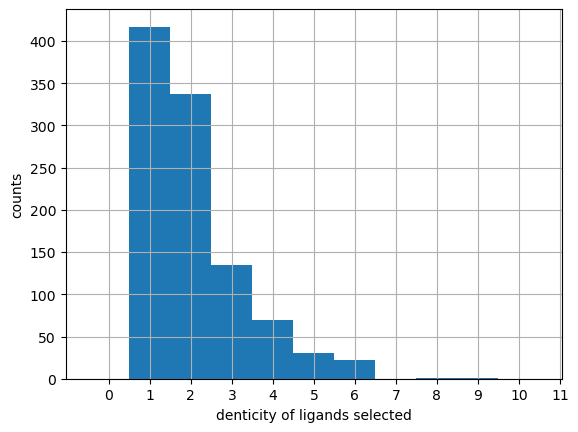

In [31]:
ax = outdf.denticity.hist(bins=np.arange(0,12,1),align='left')
ax.set_xlabel('denticity of ligands selected')
ax.set_ylabel('counts')
ax.set_xticks(np.arange(0,12,1));

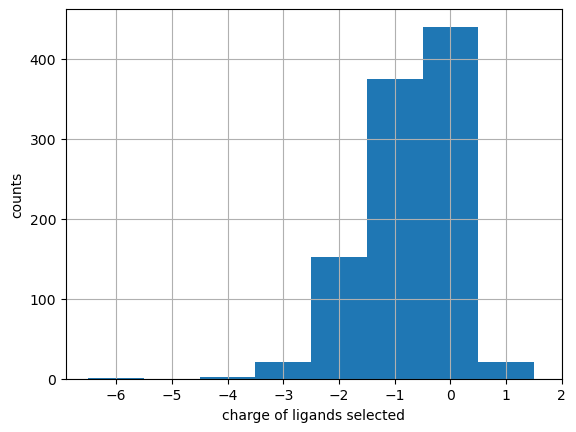

In [32]:
bins = np.arange(-6,3,1)
ax = outdf.charge.hist(bins=bins,align='left')
ax.set_xlabel('charge of ligands selected')
ax.set_ylabel('counts')
ax.set_xticks(bins);

Text(0, 0.5, 'counts')

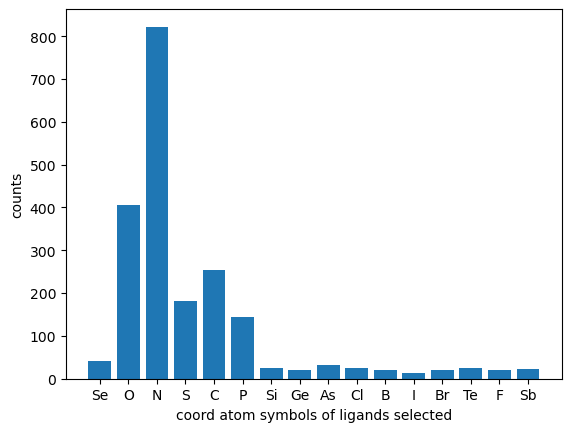

In [33]:
coord_atom_symbols = dict()
for i,row in outdf.iterrows():
    syms = row['coord_atom_symols'].split(',')
    vals,counts = np.unique(syms,return_counts=True)
    for j,val in enumerate(vals):
        coord_atom_symbols.update({val:coord_atom_symbols.get(val,0)+counts[j]})
syms = list(coord_atom_symbols.keys())
vals = list(coord_atom_symbols.values())
plt.bar(syms,vals)
plt.xlabel('coord atom symbols of ligands selected')
plt.ylabel('counts')

In [35]:
# Calculate number of atoms per-ligand
natoms = [] 
for i,row in tqdm(newoutdf.iterrows(),total=newoutdf.shape[0]):
    mol = convert_io_molecule(row['smiles']) # Including H
    natoms.append(len(mol.ase_atoms))
newoutdf['natoms'] = natoms

100%|██████████| 992/992 [02:46<00:00,  5.98it/s]


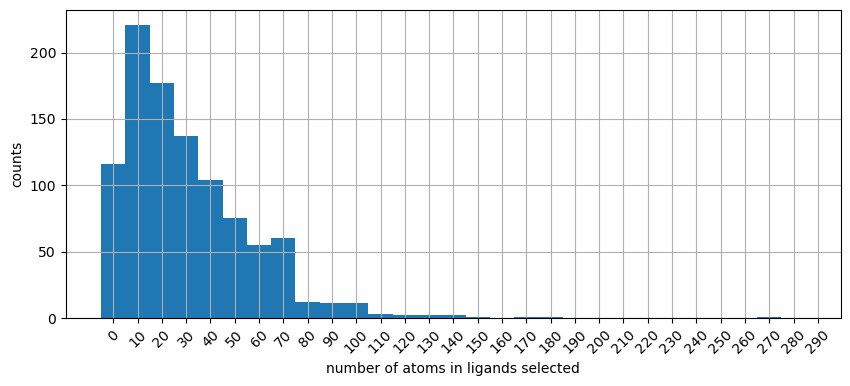

In [37]:
# Note - we should possibly down-select for number of atoms
bins = np.arange(0,300,10)
ax = newoutdf.natoms.hist(bins=bins,align='left',figsize=(10,4))
ax.set_xlabel('number of atoms in ligands selected')
ax.set_ylabel('counts')
ax.set_xticks(bins)
ax.set_xticklabels(bins,rotation=45);

In [38]:
newoutdf.to_pickle('v0_ligand_sampling_df.pkl')

In [39]:
newoutdf

,uid,smiles,coordList,coord_atom_symols,coord_atom_types,non_coord_atom_symbols,non_coord_atom_types,charge,denticity,metal_ox_bound,frequency,selected_coord_type,selected_non_coord_type,natoms
627,[Se-]c1ccccc10,[Se-]c1ccccc1,[0],Se,Se,"C,C,C,C,C,C,H,H,H,H,H","C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,H,H,H,H,H",-1,1,"Cu,1",176,Se,None,12
23393,"[Se]=P([Se-])(c1ccccc1)c1ccccc10,2",[Se]=P([Se-])(c1ccccc1)c1ccccc1,"[0, 2]","Se,Se","Se,Se","P,C,C,C,C,C,C,C,C,C,C,C,C,H,H,H,H,H,H,H,H,H,H","P.3,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C....",-1,2,"Bi,3",77,Se,None,25
32207,"[Se-][Se][Se][Se-]0,3",[Se-][Se][Se][Se-],"[0, 3]","Se,Se","Se,Se","Se,Se","Se,Se",-2,2,"Ir,3",49,Se,None,4
1803,[Se-2]0,[Se-2],[0],Se,Se,,,-2,1,"Ti,2",40,Se,None,1
12718,CN1C=CN(C)C1=[Se]7,CN1C=CN(C)C1=[Se],[7],Se,Se,"C,N,C,C,N,C,C,H,H,H,H,H,H,H,H","C.3,N.ar,C.ar,C.ar,N.ar,C.3,C.ar,H,H,H,H,H,H,H,H",0,1,"Cu,1",33,Se,None,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65980,"Cc1ccc(cc1)S(=O)(=O)[N-]c1ccccc1C=NNC1=NCCN18,...",Cc1ccc(cc1)S(=O)(=O)[N-]c1ccccc1C=NNC1=NCCN1,"[8, 10, 18, 21]","O,N,N,N","O.2,N.pl3,N.2,N.2","C,C,C,C,C,C,C,S,O,C,C,C,C,C,C,C,N,C,C,C,N,H,H,...","C.3,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,S.O2,O.2,C.a...",-1,4,"Cu,2",1,None,S.O2,43
330542,CN1C(=C([O-])c2ccccc2S1(=O)=O)C(=O)NC1=NC=C(C)...,CN1C(=C([O-])c2ccccc2S1(=O)=O)C(=O)NC1=NC=C(C)S1,"[15, 18]","O,N","O.2,N.ar","C,N,C,C,O,C,C,C,C,C,C,S,O,O,C,N,C,C,C,C,S,H,H,...","C.3,N.pl3,C.2,C.2,O.co2,C.ar,C.ar,C.ar,C.ar,C....",-1,2,"Ni,2",4,None,S.O2,35
348185,Cc1ccc(cc1)S(=O)(=O)CC[CH2-]12,Cc1ccc(cc1)S(=O)(=O)CC[CH2-],[12],C,C.2,"C,C,C,C,C,C,C,S,O,O,C,C,H,H,H,H,H,H,H,H,H,H,H,H,H","C.3,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,S.O2,O.2,O.2...",-1,1,"Sn,4",1,None,S.O2,26
103117,CCOC(=O)COc1cc2ccc(C)nc2c(c1)[N-]S(=O)(=O)c1cc...,CCOC(=O)COc1cc2ccc(C)nc2c(c1)[N-]S(=O)(=O)c1cc...,"[14, 18]","N,N","N.ar,N.pl3","C,C,O,C,O,C,O,C,C,C,C,C,C,C,C,C,C,S,O,O,C,C,C,...","C.3,C.3,O.3,C.2,O.2,C.3,O.3,C.ar,C.ar,C.ar,C.a...",-1,2,"Zn,2",1,None,S.O2,51


In [41]:
view_structures(newoutdf.sample(12,random_state=42).smiles)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [43]:
view_structures(newoutdf.nsmallest(20,'natoms').smiles)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [44]:
newoutdf.iloc[0]

uid                                                 [Se-]c1ccccc10
smiles                                               [Se-]c1ccccc1
coordList                                                      [0]
coord_atom_symols                                               Se
coord_atom_types                                                Se
non_coord_atom_symbols                       C,C,C,C,C,C,H,H,H,H,H
non_coord_atom_types       C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,H,H,H,H,H
charge                                                          -1
denticity                                                        1
metal_ox_bound                                                Cu,1
frequency                                                      176
selected_coord_type                                             Se
selected_non_coord_type                                       None
natoms                                                          12
Name: 627, dtype: object

In [45]:
view_structures(newoutdf.nlargest(12,'frequency').smiles)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [46]:
view_structures(newoutdf.nlargest(12,'natoms').smiles)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol